# Кластеризация.

[Кластеризация](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7) - это один из видов задач обучения без учителя. Задача заключается в разбиении всех объектов на группы похожих между собой объектов и сильно отличающихся от всех остальных. Так как строгого понятия похожести объектов как такового нет, то алгоритмов кластеризации много, да и каждый алгоритм имеет много вариантов работы.

![](http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png)

## KMeans

Метод k-means - это один из наиболее популярных методов кластеризации. Основная идея метода заключается в том, что на каждой итерации пересчитывается центр масс (центроид) для каждого кластера, полученного на предыдущем шаге, затем объекты снова разбиваются на кластеры согласно тому, какой из новых центроидов находится ближе.
Более формально, алгоритм принимает на вход выборку $X_1, \dots, X_N$ и параметр $k$, указывающий необходимое число кластеров. Выходом алгоритма является набор из $k$ центроидов $\{\mu_1, \dots, \mu_k\}$, с помощью которых кластеризация осуществляется путём отнесения каждого объекту к ближайшему центроиду. Все точки внутри одного кластера ближе к центроиду этого кластера, чем к центроиду любого другого кластера.
Метод может быть сформулирован как задача оптимизации, а именно, минимизации суммарного квадратичного отклонения точек кластеров от центров этих кластеров по центроидам и кластерам: $$\sum_{i=1}^k \sum_{X_n \in C_i} ||X_n - \mu_i||^2 \rightarrow \min, \text{где $C_i$ - это $i$-ый кластер, $\mu_i$ - это центр масс кластера $C_i$.}$$
Решение такой задачи оптимизации является NP-трудной задачей, однако существует простой итеративный алгоритм, позволяющий найти локальный минимум указанного функционала. Алгоритм представляет собой последовательное чередование двух шагов до сходимости.
Предположим, что как-то (например, случайно) выбраны начальные положения центроидов $\mu_1, \dots, \mu_k$.

1. Этап кластеризациu. На данном этапе происходит кластеризация выборки, как было описано выше: каждый объект относится к кластеру ближайшего к нему центроида. Формально, $$C_i = \{X_n : ||X_n - \mu_i|| \leq ||X_n - \mu_j||, \text{ для всех $j \in \{1, \dots, k\}$}\}.$$

2. Этап обновления центроидов. На данном этапе центроиды пересчитываются, как центры масс только что построенных кластеров. Формально, $$\mu_i = \frac{1}{|C_i|}\sum_{X_n \in C_i} X_n.$$

Этот процесс продолжается, пока центроиды и кластеризация продолжают изменяться. Алгоритм гарантированно сходится, однако не гарантируется достижение глобального минимума, а только одного из локальных минимумов. Другим недостатком алгоритма является то, что итоговая кластеризация зависит от выбора исходных центров кластеров. На практике алгоритм запускается несколько раз из различных начальных приближений, а полученные результаты некоторым образом усредняются. Стоит также отметить, что число кластеров необходимо знать заранее. Существуют различные эвристики, позволяющие выбирать в некотором смысле оптимальное число кластеров.

_определение взято из материалов курса [ODS](https://habrahabr.ru/company/ods/)_

### Литература

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random 
from tqdm.notebook import tqdm
from skimage.io import imread

%matplotlib inline

# Зафиксируем случайность, чтобы у нас получались одинаковые результаты.
np.random.seed(seed=42)

## Рассмотрим как работает алгоритм кластеризации KMeans на синтетическом примере.

Бросим на плоскость случайно точки с разными параметрами случайности, чтобы образовались кластеры.

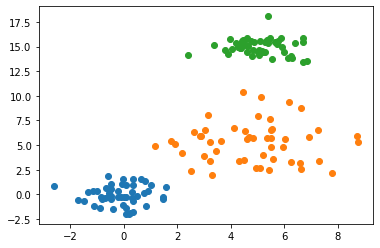

In [ ]:
p1 = np.random.normal(loc=0, scale=1, size=(50,2))
p2 = np.random.normal(loc=5, scale=2, size=(50,2))
p3 = np.random.normal(loc=10, scale=0.8, size=(50,2)) - np.array([5, -5])

X = np.concatenate((p1, p2, p3))

plt.scatter(p1[:,0], p1[:, 1])
plt.scatter(p2[:,0], p2[:, 1])
plt.scatter(p3[:,0], p3[:, 1])

Нарисуем точки на плоскости, но без окрашивания точек. Так будет видеть данные алгоритм. Можем ли мы сами понять где и какие кластеры?

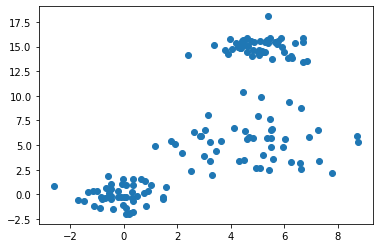

In [ ]:
plt.scatter(X[:, 0], X[:, 1])

Рассмотрим пошагово работу алгоритма KMneans на основе обычного евклидова расстояния.  

_Пример из блога ODS: https://habrahabr.ru/company/ods/blog/325654/_

### 1.1 Напишите функицю, которая расстояние от центра кластера до к каждой точки и возвращяет к какому кластеру каждая точка принадлежит.

In [ ]:
def kmeans_predict(x, clusters):

    labels = np.zeros(x.shape[0], dtype=np.int)
    distances = np.zeros((len(clusters), len(x)), dtype=np.float32)

    # Считаем расстояния от наблюдений до центроид
    for i in range(0, len(clusters)):
        for j in range(0, len(x)):
            distances[i][j] = np.linalg.norm(clusters[i] - x[j])

    # Смотрим, до какой центроиды каждой точке ближе всего
    for i in range(0, distances.shape[1]):
        labels[i] = np.argmin(distances[:,i])
    return labels

# В scipy есть замечательная функция, которая считает расстояния
# между парами точек из двух массивов, подающихся ей на вход
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
# Это сократит кол-во for и из-за этого код будет работать намного быстрее
# Но так нагляднее

Проверяем что получилось

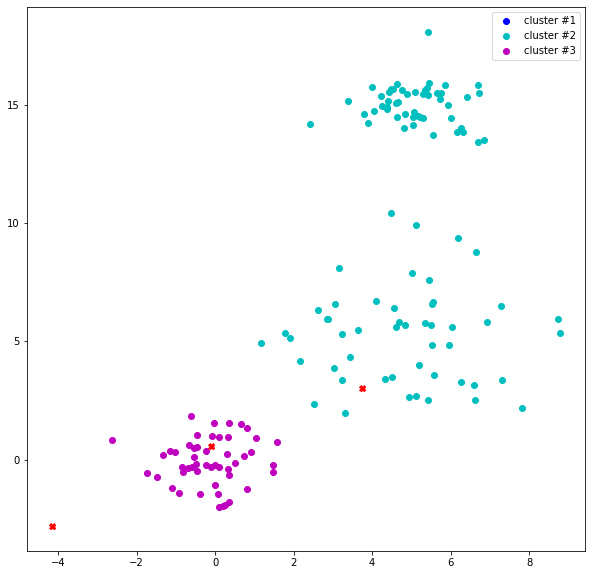

In [ ]:
# Генерируем случайный координаты для центров кластеров
centroids = np.random.normal(loc=0.0, scale=5., size=6)
centroids = centroids.reshape((3, 2)) # итого получаем 3 точки в двумерном пространстве

plt.figure(figsize=(10, 10))
labels = kmeans_predict(X, centroids)

plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
plt.plot(centroids[:, 0], centroids[:, 1], 'rX')
plt.legend(loc=0)

### 1.2 Напишите код для обновления центров кластеров. Запоминайте центры кластеров это понадобиться потом для визуализации.
Для упрощения каждому облачку данных зарание присовим кластер.<br>
Положим в каждую новую центроиду геометрический центр её точек.<br>

In [ ]:
centroids = np.random.normal(loc=0.0, scale=1., size=6).reshape((3, 2))

cent_history = [] # История центоров кластеров
cent_history.append(centroids)

STEPS = 5 # количество шагов итерации обновления центров кластеров

for i in range(STEPS):
    labels = kmeans_predict(X, centroids)

    # Положим в каждую новую центроиду геометрический центр её точек
    centroids = centroids.copy() # копируем чтобы в массиве cent_history ничего не попортить при модификации объекта
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)

    cent_history.append(centroids)

А теперь нарисуем всю эту красоту

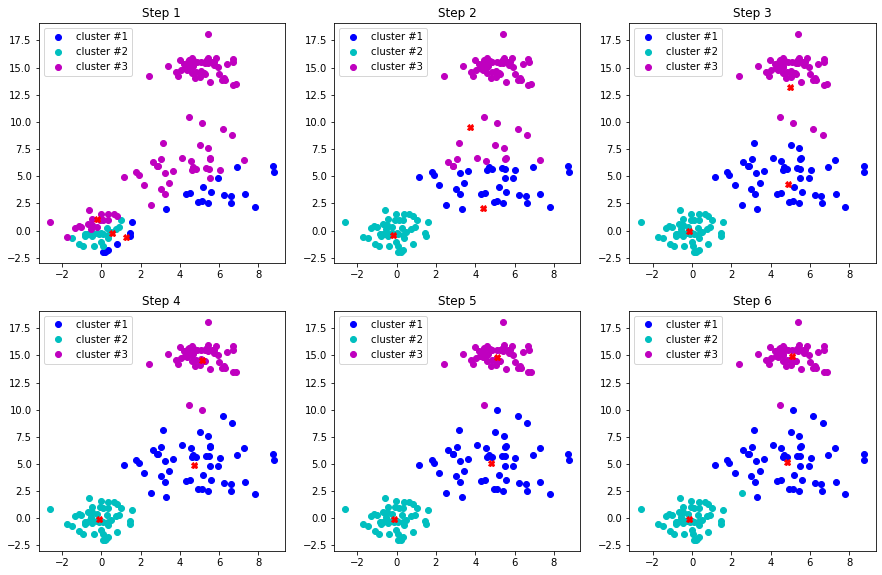

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(STEPS + 1):
    labels = kmeans_predict(X, cent_history[i])

    plt.subplot((STEPS + 1) // 2, (STEPS + 1) // 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

Обратите внимание, последние 3 шага уже не сильно изменили координаты центров кластеров и состав кластеров.

### 1.3 Напишите функцию обучения kMeans, которая возвращает центры кластеров и к какому кластеру принадлежит каждая точка. 

* k - кол-во кластеров
* max_iter - через сколько итераций остановится
* tol - если сумма расстояний между прошлыми центрами кластеров и новыми центрами меньше tol, то остановится
* low и high - это минимально и максимально значение которое могут принимать точки центров кластеров при генерации

In [ ]:
def kmeans_fit(x, k=8, max_iter=100, tol=0.1, low=0.0, high=1.0):
    size = 1
    if len(x.shape) == 2: # если у одномерного массива в numpy попросить shape[1] будет ошибка(
        size = x.shape[1]

    clusters = np.random.uniform(low=low, high=high, size=(k, size)) 

    iter = 0

    while iter <= max_iter:
        labels = kmeans_predict(x, clusters)
     
        pred_clusters = clusters.copy()
        for i in range(0, len(clusters)):
            if len(x[labels == i]) == 0: # это если вдруг центр кластера оказался без точек 
                clusters[i] = np.random.uniform(low=low, high=high, size=(1, size))
            else: 
                clusters[i] = np.average(x[labels == i], axis=0)
     
        loss = np.sum((clusters - pred_clusters)) 
        loss = np.abs(loss)

        print(f"Итерация = {iter} loss = {loss}")
             
        if loss < tol:
            break
     
        iter += 1

    return clusters, labels

## MNIST

Рассморим датасет рукописных цирф MNIST http://yann.lecun.com/exdb/mnist/

In [ ]:
from sklearn import datasets

X, y = datasets.load_digits(return_X_y=True) # мы можем сразу же загрузить этот игрушечный датасет

print("Экземпляров: {}\nРазмер изображения: {}x{}".format(X.shape[0], np.sqrt(X.shape[1]), np.sqrt(X.shape[1])))

Экземпляров: 1797
Размер изображения: 8.0x8.0


#### 2.1 Выведите первые 10 экземпляров данных
###### Подсказка: используйте plt.subplot и reshape так как это картинки.

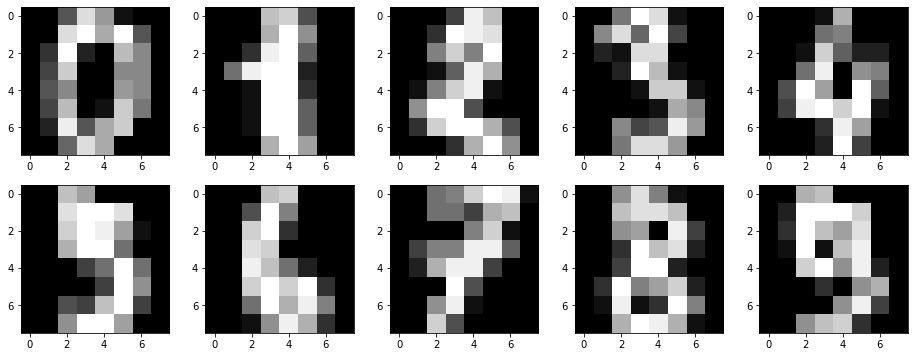

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray')

In [ ]:
clusters_, labels_ = kmeans_fit(X, k=10, low=0.0, high=np.max(X), tol=5)

Итерация = 0 loss = 1559.5101208688593
Итерация = 1 loss = 24.869306694368156
Итерация = 2 loss = 36.406182569892614
Итерация = 3 loss = 104.3747998610368
Итерация = 4 loss = 192.4680166314377
Итерация = 5 loss = 64.0509363384379
Итерация = 6 loss = 31.765101963757285
Итерация = 7 loss = 80.69752729941698
Итерация = 8 loss = 108.03039558254481
Итерация = 9 loss = 61.28312239945383
Итерация = 10 loss = 83.79623125058505
Итерация = 11 loss = 147.97002087786953
Итерация = 12 loss = 0.4014096468871786


8 8 8 8 8 8 8 8 8 8 

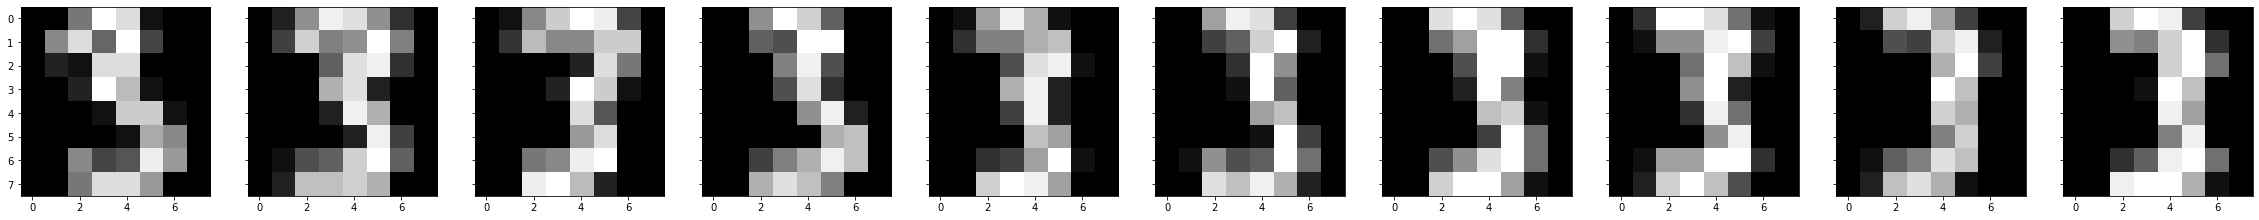

In [ ]:
number = 3 
count = 10
testX = X[y == number]

testX[0,:].reshape([8,8])
f, axes = plt.subplots(1, count, sharey=True, figsize=(40,6))
for i in range(count):
    print(labels_[y == number][i], end=' ')
    axes[i].imshow(testX[i,:].reshape([8,8]), cmap='gray')

## Центры кластеров фотографий

Можно найти центры кластеров по фотографиям людей....

In [ ]:
# загрузим датасет с фотографиями знаменитостей
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=50, resize=0.4)

Ariel Sharon: 77 photos.
Colin Powell: 236 photos.
Donald Rumsfeld: 121 photos.
George W Bush: 530 photos.
Gerhard Schroeder: 109 photos.
Hugo Chavez: 71 photos.
Jacques Chirac: 52 photos.
Jean Chretien: 55 photos.
John Ashcroft: 53 photos.
Junichiro Koizumi: 60 photos.
Serena Williams: 52 photos.
Tony Blair: 144 photos.


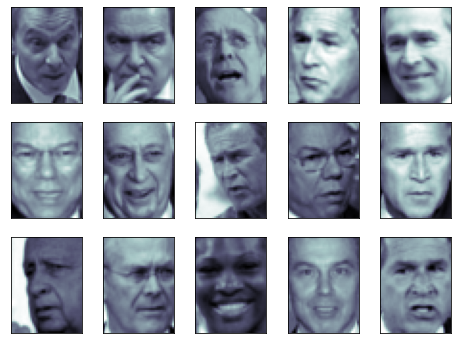

In [ ]:
fig = plt.figure(figsize=(8, 6))

for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap='bone')

for i, name in enumerate(lfw_people.target_names):
    print("{}: {} photos.".format(name, (lfw_people.target == i).sum()))

### 3.1 Натренеруйте kMeans и нарисуйте центры кластеров как картики выше.

Итерация = 0 loss = 13134.98003726924
Итерация = 1 loss = 12164.17896613786
Итерация = 2 loss = 13166.020654738884
Итерация = 3 loss = 4725.061150590622
Итерация = 4 loss = 3936.712493124787
Итерация = 5 loss = 10766.84316391819
Итерация = 6 loss = 3001.3928430004166
Итерация = 7 loss = 13104.625153326004
Итерация = 8 loss = 3394.138625418105
Итерация = 9 loss = 5079.61853626033
Итерация = 10 loss = 3535.0104105879154
Итерация = 11 loss = 4814.301588903379
Итерация = 12 loss = 3636.167411693339
Итерация = 13 loss = 6122.913705159761
Итерация = 14 loss = 2217.722732939203
Итерация = 15 loss = 2735.662412760509
Итерация = 16 loss = 3133.583316852284
Итерация = 17 loss = 2374.599388954996
Итерация = 18 loss = 9304.974225150978
Итерация = 19 loss = 1302.5882415220897
Итерация = 20 loss = 2588.5811404467977
Итерация = 21 loss = 2448.3836694680576
Итерация = 22 loss = 489.2023148974972
Итерация = 23 loss = 5703.604912318025
Итерация = 24 loss = 3612.800082113948
Итерация = 25 loss = 1380.805

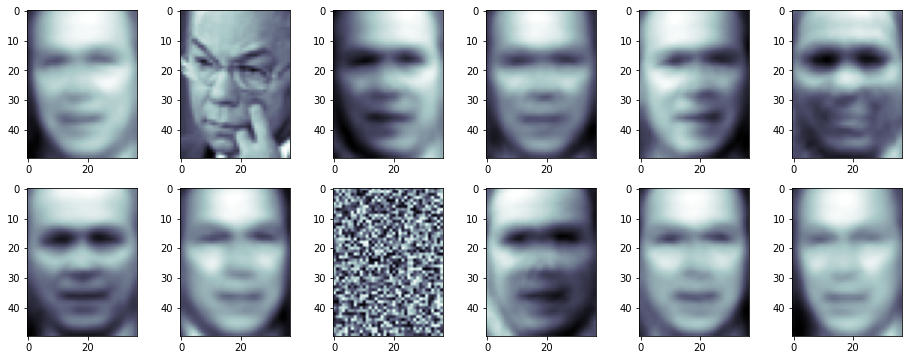

In [ ]:
clusters_, labels_ = kmeans_fit(lfw_people.data, k=12, low=0.0, high=np.max(lfw_people.data), tol=100)

plt.figure(figsize=(16, 6))

for i, center in enumerate(clusters_):
    plt.subplot(2, 6, i + 1)
    plt.imshow(center[:].reshape([50,37]), cmap='bone')

## Птичка 

С помощью алгоритмов кластеризации можно уменьшить число цветов в изображении. В данном случае будут кластеризоваться похожие пиксели. Такой подход позволяет перейти к суперпиксельному представлению изображений, которое является более компактным и используется в задачах компьютерного зрения.

Загрузим картинку `data/bird.jpg` с помощью scikit-image и выведите ее с помощью matplotlib.

In [ ]:
colab = True # если работаете на своём компьютере, поставьте False
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

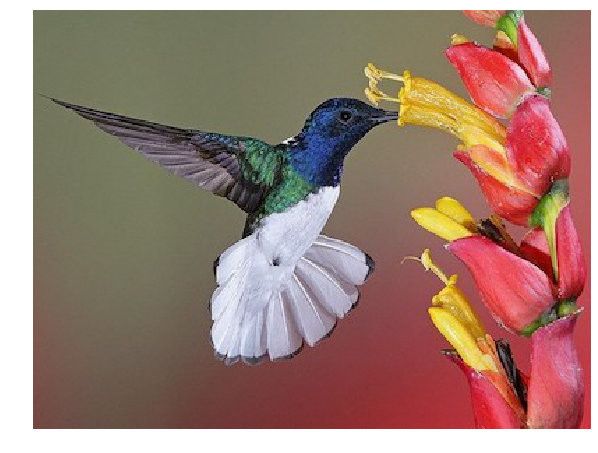

In [ ]:
%matplotlib inline
from skimage.io import imread
from matplotlib import pyplot as plt
import numpy as np

if colab:
    img = imread("/content/drive/My Drive/Data/bird.jpg")
else:
    img = imread("../../data/bird.jpg")
plt.figure(figsize=(10,15))
plt.axis('off')
plt.imshow(img)

### 1.1 Scale (0.5 балла)

Если вы посмотрите на содержимое numpy массива, в котором хранится изображение, то увидите, что там будут числа от 0 до 255. Нам лучше перейти к числам от 0 до 1. 

**Преобразуйте вашу матрицу, как сказано выше.**

**Hint**: Это можно сделать с помощью функции `skimage.img_as_float`.

In [ ]:
img = skimage.img_as_float(img)

### 1.2 Reshape (1 балл)

Мы получили матрицу размера `(300, 400, 3)`. Нам это не подходит. Чтобы запустить kMeans нам нужно иметь много-много объектов и 3 признака - значение яркости пикселя в канале Red, Green и Blue. 

**Преобразуйте матрицу так, чтобы получилась матрица размера `(120000, 3)`. **

**Hint**: Вам пригодятся функции: `np.ravel` и `np.vstack`.

In [ ]:
X = np.vstack(img)

### 1.3 Train (0.5 балла)

Отлично. У нас есть подготовленные данные. Теперь мы будем находить кластеры похожих пикселей по цвету. Для этого создайте KMeans для, например, 8 цветов. **Обучите модель** (может занять около 10 секунд). С помощью магического макроса `%time` **покажите, сколько времени у вас занимало обучение**.

In [ ]:
clusters, labels = kmeans_fit(X, k=8, low=np.min(X), high=np.max(X))
clusters

### 1.4 Draw centroids (1 балл)

**Нарисуйте с помощью imshow центры кластеров**: будет 8 пикселей со средним цветом по всему кластеру. 
Это называется цветовой палитрой. 

**Hint**: reshape в 3 мерный массив, так как у вас будет 2-мерный

In [ ]:
plt.imshow(clusters.reshape(clusters.shape[0], 1, clusters.shape[1]))

### 1.5 Draw final image (3 балла)

У нас есть значения цвета для каждого центра кластера. Каждый пиксель в результате обучения KMeans теперь имеет свой лейбл кластера. Значит мы можем заменить все пиксели на соответсвующие им центры класетров. Проведите это преобразование и выведите 8-цветное изображение.

**Hints**: `labels_`, `reshape`, `copy`, логические маски в numpy `arr[arr == 1] = 0`. У меня это 7 строк кода.

In [ ]:
X_compressed = clusters[labels]
X_compressed = np.clip(X_compressed.astype('float'), 0, 1)
X_compressed = X_compressed.reshape(img.shape[0], img.shape[1], img.shape[2])
plt.imshow(X_compressed)

## Визуализация 64-мерного простарансва использую PCA

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA - Метод главных компонент.

![](http://scikit-learn.org/stable/_static/scikit-learn-logo-small.png)

Далее мы будем использовать библиотеку [scikit-learn](http://scikit-learn.org/). По сути это библиотека-набор разных алгоритмов анализа данных, машинного обучения.

Документация по библиотеке всегда доступна:
- по ? в jupyter
- по комбинации shift-tab в jupyter
- на сайте http://scikit-learn.org/stable/documentation.html

Просто так визуализировать 64-мерный объект не получится, нам нужно уменьшить его размерность до 2, чтобы он укладывался на плоскость.

Существует специальный алгоритм PCA -  [Метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82).

Нарисуем scatter plot для тренировочной выборки: на графике у нас будут точки, помеченные лейблом - цифрой которую обозначает эта точка в пространстве.

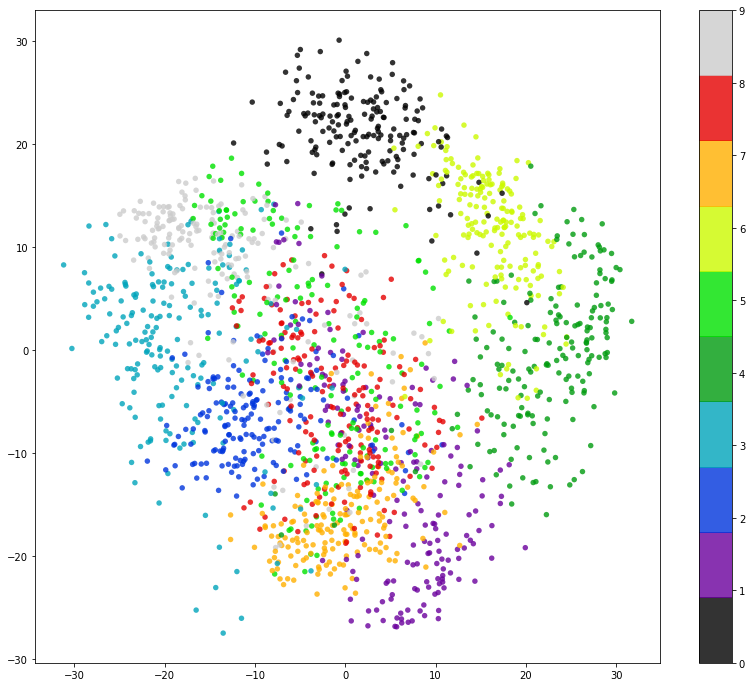

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42) # 2 компоненты, значит 2-мерное представление

X_reduced = pca.fit_transform(X)
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

А теперь посмотрим как расставил границы наш алгоритм KMeans. Как видим - хоть цвета и перепутаны, но сами кластеры угадываются.

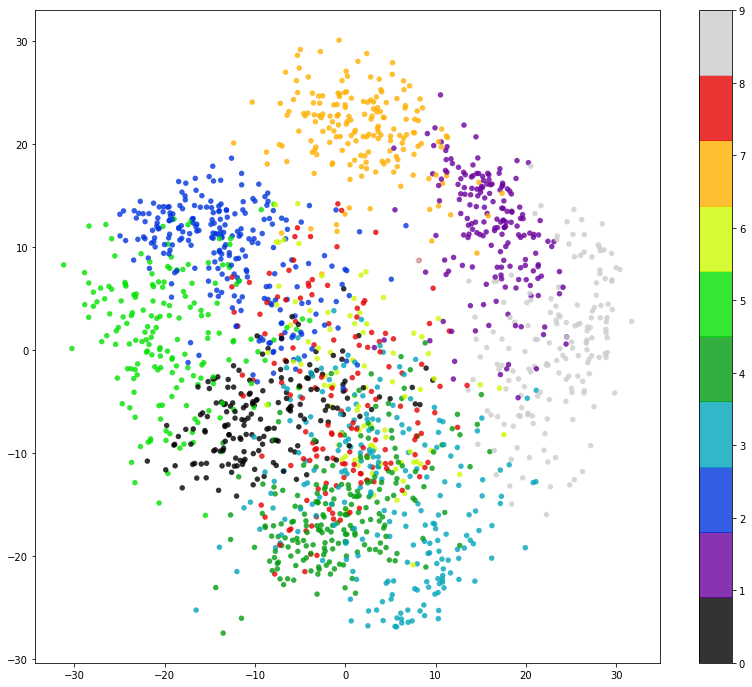

In [ ]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=clf.labels_, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Центры кластеров представляют из себя нечто среднее, окруженное максимально "похожими" на них элементами. Поэтому мы можем предположить, что на визуализации, центры кластеров будут похожи на цифры.

Центры кластеров можно получить у модели `clf.cluster_centers_`.

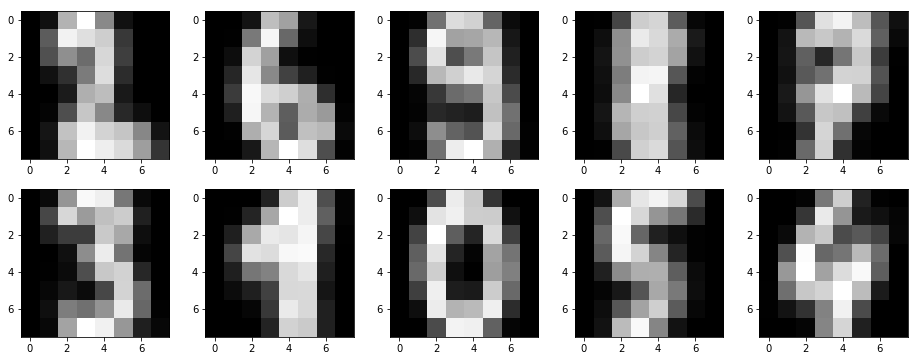

In [ ]:
plt.figure(figsize=(16, 6))

for i, center in enumerate(clf.cluster_centers_):
    plt.subplot(2, 5, i + 1)
    plt.imshow(center[:].reshape([8,8]), cmap='gray')

Существуют и другие методы понижения размерности, например t-SNE, но он намного медленнее чем PCA.

Мы пока что не изучаем как именно работают PCA и tSNE, просто восхтимся их способностями.

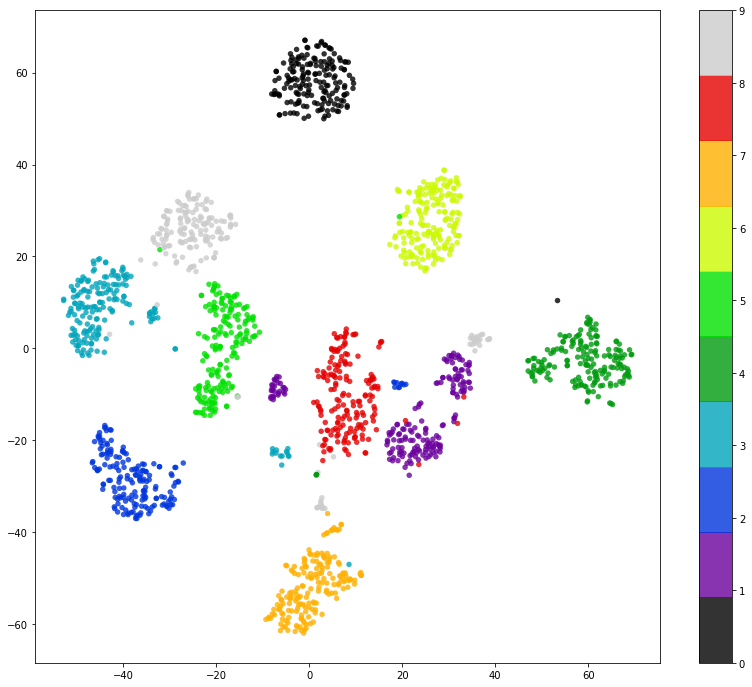

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=42)
X_reduced_t = tsne.fit_transform(X)

plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=y, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()

Теперь нарисуем тот же scatter-plot, только на основе лейблов из kMeans. Ожидаем что кластеры будут покрашены в нужные цвета.

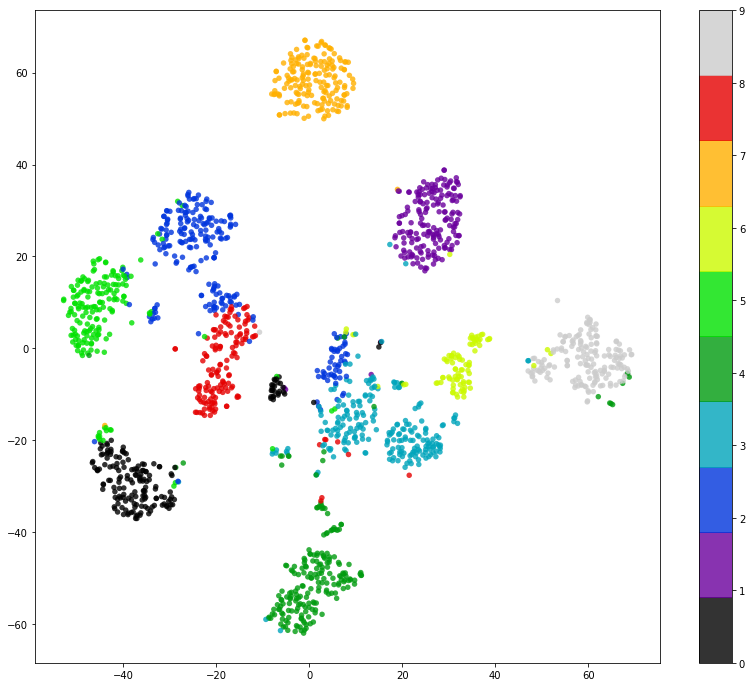

In [ ]:
plt.figure(figsize=(14,12))
plt.scatter(X_reduced_t[:,0], X_reduced_t[:,1], c=clf.labels_, cmap=plt.cm.get_cmap('nipy_spectral', 10),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()



---



## Бонусная секция

## Playboy

Анализ изменений стандартов красоты девушек на основе статистики журнала Playboy за последние 55 лет.

Мы с вами проверим, можно ли с помощью KMeans определить кластеры по размерам и соотнести их с годом.

In [ ]:
colab = True # вы знаете правила
if colab:
    from google.colab import drive
    drive.mount('/content/drive/')

In [ ]:
if colab:
    df = pd.read_csv('/content/drive/My Drive/Data/girls.csv')
else:
    data = pd.read_csv('../../data/girls.csv')
data.head()

,Month,Year,Bust,Waist,Hips,Height,Weight
0,December,1953,91,61,91,165,54
1,March,1954,86,61,89,168,54
2,July,1955,91,61,91,166,52
3,December,1955,91,61,91,166,52
4,July,1956,91,61,86,157,48


/Users/ilya/.pyenv/versions/3.7.0/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


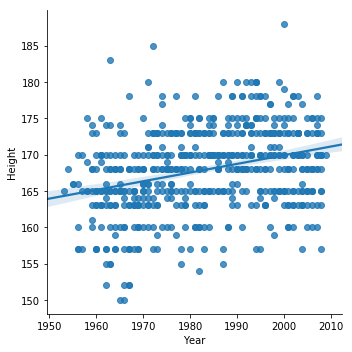

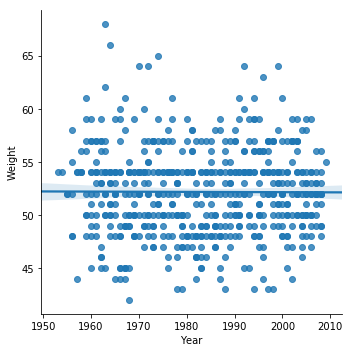

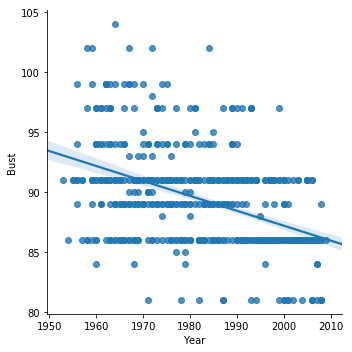

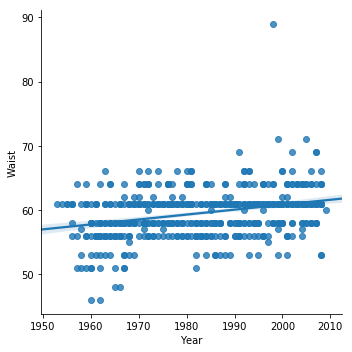

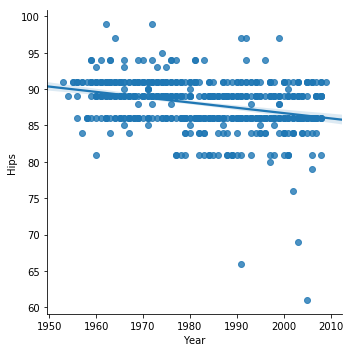

In [ ]:
sns.lmplot(x='Year', y='Height', data=data)
sns.lmplot(x='Year', y='Weight', data=data)
sns.lmplot(x='Year', y='Bust',   data=data)
sns.lmplot(x='Year', y='Waist',  data=data)
sns.lmplot(x='Year', y='Hips',   data=data)

Вывод:

|Метрика|Изменение|
|-------|
|Рост|+|
|Вес|=|
|Грудь|-|
|Талия|=|
|Бедра|-|

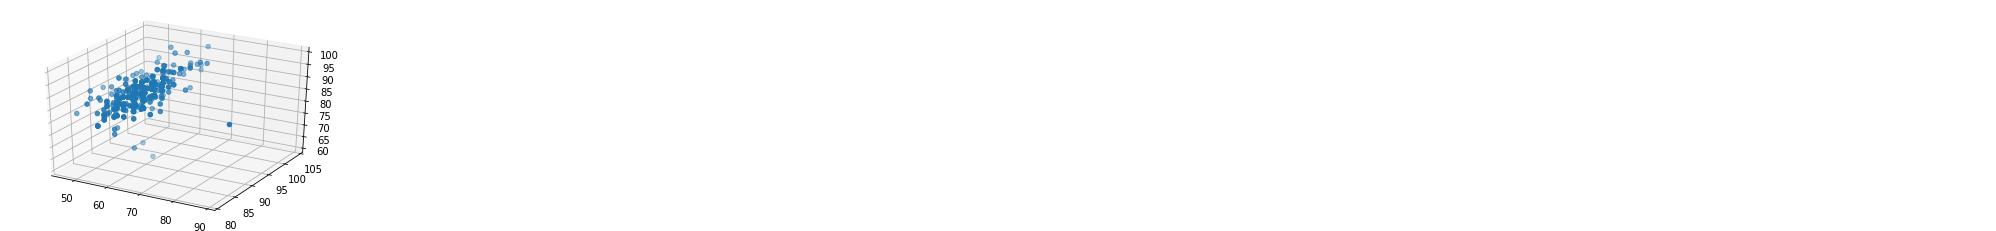

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['Waist'], data['Bust'], data['Hips'])

Ничего не видно на триде графике. Нужно спроецировать его на плоскость каким-то хитрым способом. 

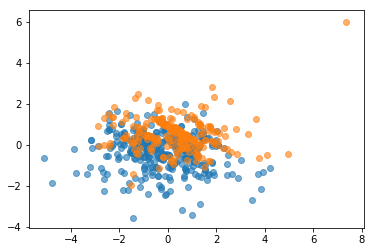

In [ ]:
from sklearn.decomposition import PCA  # инструмент понижения размерности
from sklearn.preprocessing import RobustScaler  # нормальзация признаков

pca = PCA(n_components=2)
s = RobustScaler()
p = pca.fit_transform(s.fit_transform(data[['Bust','Waist','Hips', 'Height', 'Weight']]))

data['px'] = p[:,0]
data['py'] = p[:,1]

date = 1990
old = data[data['Year'] < date]
new = data[data['Year'] >= date]
plt.scatter(old['px'], old['py'], alpha=0.6)
plt.scatter(new['px'], new['py'], alpha=0.6)

4


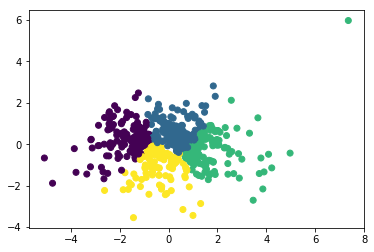

In [ ]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=4)
x = data[['Bust','Waist','Hips', 'Height', 'Weight']]
clf.fit(s.fit_transform(x))

data['label'] = clf.labels_
plt.scatter(data['px'], data['py'], c=clf.labels_)
print(len(set(clf.labels_)))

,Bust,Waist,Hips,Height,Weight
label,,,,,
0,87.080537,56.100671,84.953020,163.087248,47.758389
1,87.388350,61.111650,87.373786,168.252427,51.927184
2,91.992857,62.892857,90.728571,172.457143,56.514286
3,92.449541,56.908257,89.522936,167.889908,53.073394


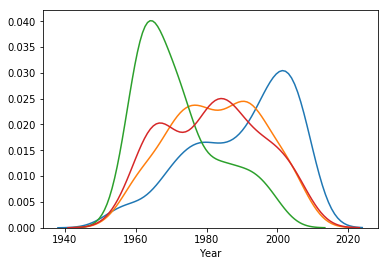

In [ ]:
for i in data['label'].unique():
    sns.distplot(data[data['label'] == i]['Year'],hist=False)
data.groupby('label')[['Bust', 'Waist', 'Hips', 'Height', 'Weight']].mean()